# Set up notebook

In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import flask
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing, decomposition, pipeline
from sklearn import metrics, model_selection, linear_model
import xgboost
import pickle
import json
import os

In [2]:
plt.style.use("fivethirtyeight")

In [3]:
plt.rcParams["figure.figsize"]=[5.0, 3.0]

In [4]:
pd.set_option("max_colwidth",0)

# Load data

In [5]:
df = pd.read_csv("../data/listings.csv.gz", low_memory=False)

In [6]:
df.columns

Index([u'id', u'listing_url', u'scrape_id', u'last_scraped', u'name',
       u'summary', u'space', u'description', u'experiences_offered',
       u'neighborhood_overview', u'notes', u'transit', u'access',
       u'interaction', u'house_rules', u'thumbnail_url', u'medium_url',
       u'picture_url', u'xl_picture_url', u'host_id', u'host_url',
       u'host_name', u'host_since', u'host_location', u'host_about',
       u'host_response_time', u'host_response_rate', u'host_acceptance_rate',
       u'host_is_superhost', u'host_thumbnail_url', u'host_picture_url',
       u'host_neighbourhood', u'host_listings_count',
       u'host_total_listings_count', u'host_verifications',
       u'host_has_profile_pic', u'host_identity_verified', u'street',
       u'neighbourhood', u'neighbourhood_cleansed',
       u'neighbourhood_group_cleansed', u'city', u'state', u'zipcode',
       u'market', u'smart_location', u'country_code', u'country', u'latitude',
       u'longitude', u'is_location_exact', u'prope

In [7]:
features = ["id", "neighbourhood_group_cleansed", "neighbourhood_cleansed", "accommodates", "bedrooms", "room_type", "price"]

In [8]:
df2 = df.copy()[features]

In [9]:
df2.head()

,id,neighbourhood_group_cleansed,neighbourhood_cleansed,accommodates,bedrooms,room_type,price
0,4717459,Manhattan,Hell's Kitchen,4,1.0,Entire home/apt,$200.00
1,9436049,Brooklyn,Bedford-Stuyvesant,2,1.0,Private room,$59.00
2,6028165,Manhattan,Chinatown,2,1.0,Entire home/apt,$200.00
3,5604005,Manhattan,Nolita,4,2.0,Entire home/apt,$300.00
4,11271036,Manhattan,East Harlem,1,1.0,Private room,$30.00


In [10]:
df2["price"] = df2["price"].map(lambda x: float(x.strip("$").replace(",","")))

In [11]:
df2.head()

,id,neighbourhood_group_cleansed,neighbourhood_cleansed,accommodates,bedrooms,room_type,price
0,4717459,Manhattan,Hell's Kitchen,4,1.0,Entire home/apt,200.0
1,9436049,Brooklyn,Bedford-Stuyvesant,2,1.0,Private room,59.0
2,6028165,Manhattan,Chinatown,2,1.0,Entire home/apt,200.0
3,5604005,Manhattan,Nolita,4,2.0,Entire home/apt,300.0
4,11271036,Manhattan,East Harlem,1,1.0,Private room,30.0


In [12]:
df2[df2["neighbourhood_cleansed"] == "Hell's Kitchen"]["bedrooms"].value_counts()

1.0    1084
2.0    215 
0.0    171 
3.0    40  
4.0    8   
Name: bedrooms, dtype: int64

In [13]:
n = df2.groupby("neighbourhood_cleansed")[["price"]].median().reset_index()
n.head()

,neighbourhood_cleansed,price
0,Allerton,50.0
1,Arden Heights,42.0
2,Arrochar,100.0
3,Arverne,80.0
4,Astoria,89.0


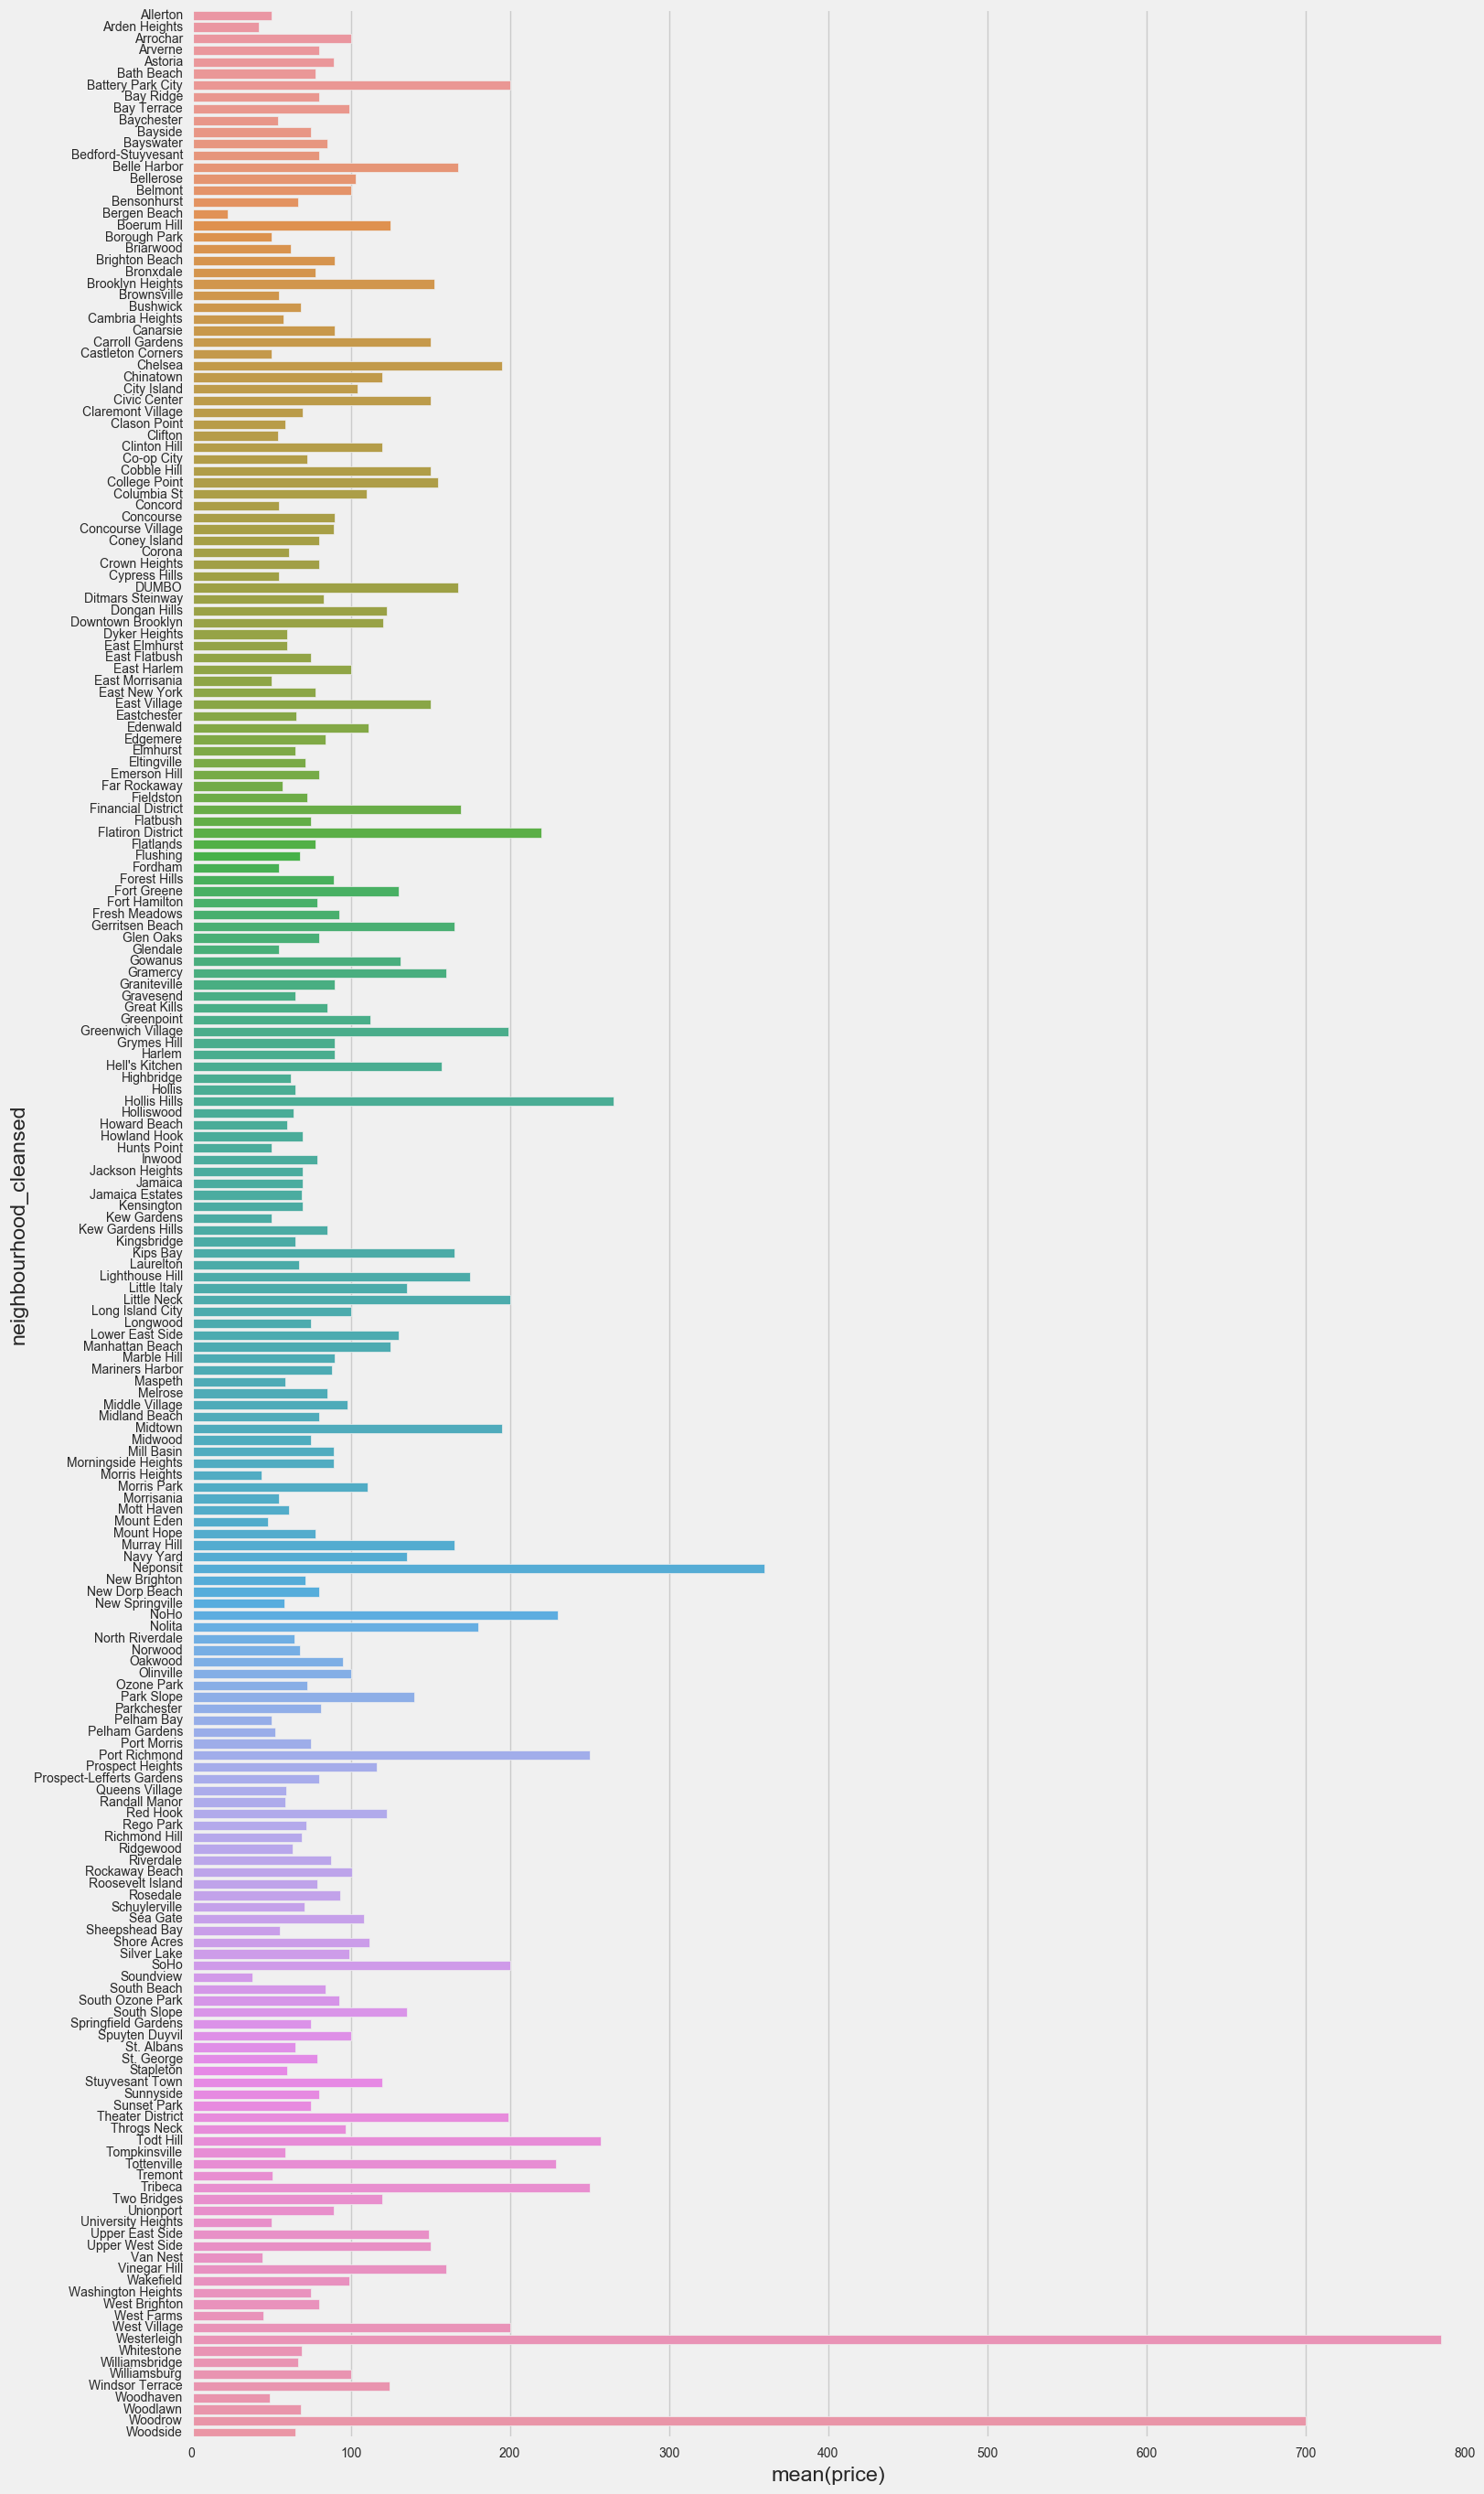

In [14]:
plt.subplots(figsize=(16,32));
sns.barplot(y="neighbourhood_cleansed", x="price", orient="h", data=n);
plt.show();

In [15]:
df2.head()

,id,neighbourhood_group_cleansed,neighbourhood_cleansed,accommodates,bedrooms,room_type,price
0,4717459,Manhattan,Hell's Kitchen,4,1.0,Entire home/apt,200.0
1,9436049,Brooklyn,Bedford-Stuyvesant,2,1.0,Private room,59.0
2,6028165,Manhattan,Chinatown,2,1.0,Entire home/apt,200.0
3,5604005,Manhattan,Nolita,4,2.0,Entire home/apt,300.0
4,11271036,Manhattan,East Harlem,1,1.0,Private room,30.0


# Data wrangling

In [16]:
df3 = df2.copy()

In [17]:
df4 = df2[["neighbourhood_group_cleansed", "neighbourhood_cleansed"]].copy()

In [18]:
df4.drop_duplicates(inplace=True)

In [19]:
df4.sort_values(by="neighbourhood_group_cleansed", inplace=True)

In [20]:
df4.reset_index(inplace=True, drop=True)

In [21]:
df4.head()

,neighbourhood_group_cleansed,neighbourhood_cleansed
0,Bronx,Hunts Point
1,Bronx,Pelham Bay
2,Bronx,Co-op City
3,Bronx,Allerton
4,Bronx,Belmont


In [22]:
boroughs_neighborhoods = {}
for i in df4["neighbourhood_group_cleansed"].unique():
    boroughs_neighborhoods[i] = list(df4["neighbourhood_cleansed"][df4["neighbourhood_group_cleansed"]==i])

In [23]:
with open("boroughs_neighborhoods.pkl", "w") as p:
    pickle.dump(boroughs_neighborhoods, p)

## room_type

In [24]:
types_of_rooms = df2["room_type"].unique()
types_of_rooms

array(['Entire home/apt', 'Private room', 'Shared room'], dtype=object)

In [25]:
room_types = {"Shared room": 0, "Private room": 1, "Entire home/apt": 2}

In [26]:
with open("room.pkl", "w") as p:
    pickle.dump(room_types, p)

In [27]:
df3["room_type"] = df3["room_type"].map(room_types)

## Split boroughs

In [28]:
boroughs = df3["neighbourhood_group_cleansed"].unique()
boroughs

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'], dtype=object)

In [29]:
manhattan = df3[df3["neighbourhood_group_cleansed"] == boroughs[0]].copy()

In [30]:
brooklyn = df3[df3["neighbourhood_group_cleansed"] == boroughs[1]].copy()

In [31]:
queens = df3[df3["neighbourhood_group_cleansed"] == boroughs[2]].copy()

In [32]:
staten = df3[df3["neighbourhood_group_cleansed"] == boroughs[3]].copy()

In [33]:
bronx = df3[df3["neighbourhood_group_cleansed"] == boroughs[4]].copy()

In [34]:
b_list = [manhattan, brooklyn, queens, staten, bronx]

In [35]:
for i, j in enumerate(boroughs):
    with open(j.lower().replace(" ", "_")+"df.pkl", "w") as p:
        pickle.dump(b_list[i], p)

## Rank neighborhoods

In [36]:
def rank_neighborhood(data):
    price = data.groupby("neighbourhood_cleansed")[["price"]].median().reset_index()
    price.sort_values(by="price", ascending=True, inplace=True)
    price = {j: i for i,j in enumerate(list(price["neighbourhood_cleansed"]))}
    data["neighbourhood"] = data["neighbourhood_cleansed"].map(price)
    return data, price

In [37]:
bn_list = {boroughs[i]: rank_neighborhood(j)[0] for i, j in enumerate(b_list)}
n_ranks = {boroughs[i]: rank_neighborhood(j)[1] for i, j in enumerate(b_list)}

In [38]:
with open("n_ranks.pkl", "w") as p:
    pickle.dump(n_ranks, p)

In [39]:
with open("bn_list.pkl", "w") as p:
    pickle.dump(bn_list, p)

# Modeling

In [40]:
boroughs

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'], dtype=object)

In [140]:
manmodel = linear_model.RidgeCV(cv=5)
brookmodel = linear_model.RidgeCV(cv=5)
queensmodel = linear_model.RidgeCV(cv=5)
simodel = linear_model.RidgeCV(cv=5)
bronxmodel = linear_model.RidgeCV(cv=5)

In [141]:
models = [manmodel, brookmodel, queensmodel, simodel, bronxmodel]

In [142]:
for i, j in enumerate(models):
    df = bn_list[boroughs[i]]
    df.dropna(inplace=True)
    X = df[["neighbourhood", "accommodates", "bedrooms","room_type"]]
    y = df["price"]
    j.fit(X, y)
    print "{}, r2: {}, MSE: {}".format(boroughs[i], j.score(X,y), np.mean(model_selection.cross_val_score(j, X, y, scoring="neg_mean_squared_error")))

Manhattan, r2: 0.17748593958, MSE: -49323.0326423
Brooklyn, r2: 0.177999539072, MSE: -24610.87365
Queens, r2: 0.12049454997, MSE: -32053.3622055
Staten Island, r2: 0.486593125375, MSE: -18582.9199694
Bronx, r2: 0.291158909117, MSE: -3389.56946718


In [143]:
model_list = {j: models[i] for i, j in enumerate(boroughs)}

In [144]:
for i in model_list.keys():
    with open(i.lower().replace(" ", "_")+".pkl", "w") as p:
        pickle.dump(model_list[i], p)

# Predicting

## Convert input

In [47]:
room_types

{'Entire home/apt': 2, 'Private room': 1, 'Shared room': 0}

In [48]:
def convert_nb(borough, nb):
    ref = n_ranks[borough]
    return ref[nb]

In [49]:
def convert_sample_input(sample):
    features = ["borough", "neighbourhood", "accommodates", "bedrooms", "room_type"]
    orig = [sample[i] for i in features]
    con = [convert_nb(orig[i-1], orig[i]) if i==1 else room_types[j] if i==4 else j for i,j in enumerate(orig)]
    return con

In [55]:
sample_input = {"borough": "Manhattan", 
                "neighbourhood": "Upper East Side", 
                "accommodates": 5, 
                "bedrooms": 0, 
                "room_type": "Private room"}

In [105]:
convert_sample_input(sample_input)

['Manhattan', 16, 1, 0, 0]

In [106]:
test = pd.DataFrame(convert_sample_input(sample_input)[1:]).T
test.columns = ["neighbourhood", "accommodates", "bedrooms","room_type"]
test

,neighbourhood,accommodates,bedrooms,room_type
0,16,1,0,0


In [108]:
test.loc[0,"accommodates"] = 2
test

,neighbourhood,accommodates,bedrooms,room_type
0,16,2,0,0


In [109]:
test.loc[0,"accommodates"]

2

In [117]:
manmodel.predict(test)[0]

99.388527

In [118]:
test

,neighbourhood,accommodates,bedrooms,room_type
0,16,2,0,0


## Changing inputs

In [125]:
def gen_output(sample_input):
    features = ["neighbourhood", "accommodates", "bedrooms","room_type"]
    X = convert_sample_input(sample_input)
    model = model_list[X[0]]
    
    old_input = pd.DataFrame(X[1:]).T
    old_input.columns = features
    original = model.predict(old_input)[0]
    
    change_list = ["neighbourhood", "accommodates", "bedrooms", "room_type"]
    out = {}
    out["original"] = original
    for i,a in enumerate(change_list):
        new_input = old_input.copy()
        if a != "accommodates":
            if new_input.loc[0, a]-1 >= 0:
                new_input.loc[0, a] = new_input.loc[0, a]-1
        else:
            if new_input.loc[0,a]-1 > 0:
                new_input.loc[0, a] = new_input.loc[0, a]-1
#         print new_input
        out[a] = [new_input.loc[0,a], model.predict(new_input)[0]]
    return out
#     return new_input

In [126]:
sample_input

{'accommodates': 1,
 'bedrooms': 0,
 'borough': 'Manhattan',
 'neighbourhood': "Hell's Kitchen",
 'room_type': 'Shared room'}

In [128]:
gen_output(sample_input)

{'accommodates': [1, 112.44414],
 'bedrooms': [0, 112.44414],
 'neighbourhood': [15, 109.76908],
 'original': 112.44414,
 'room_type': [0, 112.44414]}

## Converting outputs

In [129]:
sample_out = gen_output(sample_input)
sample_out

{'accommodates': [1, 112.44414],
 'bedrooms': [0, 112.44414],
 'neighbourhood': [15, 109.76908],
 'original': 112.44414,
 'room_type': [0, 112.44414]}

In [130]:
def unconvert_nb(borough, num):
    ref = n_ranks[borough]
    ref = {ref[k]:k for k in ref}
    return ref[num]

In [131]:
def convert_out(sample_input):
    sample_out = gen_output(sample_input)
    final_out = {}
    features = ["borough", "neighbourhood", "accommodates", "bedrooms", "room_type"]
    sample_out_list = [i for i in sample_out.keys()]
    for i in sample_out_list:
        if i == "original":
            final_out["original"] = sample_out[i]
        elif i == "neighbourhood":
            n_name = unconvert_nb(sample_input["borough"], sample_out[i][0])
            key_name = i + "_" + n_name.replace(" ", "_")
            final_out[key_name] = sample_out[i][1]
        elif i == "accommodates" or i == "bedrooms":
            key_name = i + "_" + str(sample_out[i][0])
            final_out[key_name] = sample_out[i][1]
        else:
            ref = {room_types[k]:k for k in room_types}
            key_name = i + "_" + ref[sample_out[i][0]].replace(" ", "_")
            final_out[key_name] = sample_out[i][1]
    return final_out

In [132]:
sample_input = {"borough": "Manhattan", 
                "neighbourhood": "Hell's Kitchen", 
                "accommodates": 1, 
                "bedrooms": 0, 
                "room_type": "Shared room"}

In [133]:
convert_out(sample_input)

{'accommodates_1': 112.44414,
 'bedrooms_0': 112.44414,
 'neighbourhood_Civic_Center': 109.76908,
 'original': 112.44414,
 'room_type_Shared_room': 112.44414}

In [134]:
import flask